# 2. GRI Calculation Example

This notebook demonstrates how to calculate the Global Representativeness Index (GRI) using the new `GRIAnalysis` class.

## Overview

The **GRI Scorecard** provides a comprehensive assessment of survey representativeness across three key dimensions:
1. **Country × Gender × Age**
2. **Country × Religion**
3. **Country × Environment (Urban/Rural)**

For each dimension, we calculate:
- **GRI Score**: Measures proportional accuracy (0.0 to 1.0)
- **Diversity Score**: Measures coverage breadth (0.0 to 1.0)
- **Max Possible Score**: Shows theoretical maximum given current participants

The notebook also includes:
- Top contributing segments analysis
- Visualizations of over/under-represented groups
- Impact analysis showing potential improvements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from gri import GRIAnalysis

# Set plotting style
plt.style.use('default')
sns.set_palette('husl')

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

## 1. Initialize GRI Analysis

In [2]:
# Initialize GRI Analysis with GD3 survey data
# First check if we have the raw data from the submodule
raw_path = Path('../data/raw/survey_data/global-dialogues/Data/GD3/GD3_participants.csv')
processed_path = Path('../data/processed/gd3_demographics.csv')

if raw_path.exists():
    gri = GRIAnalysis.from_survey_file(
        filepath=str(raw_path),
        survey_type='gd'
    )
elif processed_path.exists():
    # Load from processed file
    survey_data = pd.read_csv(processed_path)
    gri = GRIAnalysis(survey_data=survey_data, survey_name='GD3')
else:
    raise FileNotFoundError("No GD3 data found. Please run 'git submodule update --init --recursive'")

# Show summary
print("Survey loaded successfully!")
print(f"Participants: {len(gri.survey_data):,}")
print(f"Countries: {gri.survey_data['country'].nunique()}")
print(f"Top 5 countries: {', '.join(gri.survey_data['country'].value_counts().head().index)}")

Survey loaded successfully!
Participants: 985
Countries: 63
Top 5 countries: India, Kenya, China, United States of America, Indonesia


## 2. Calculate GRI Scorecard

In [3]:
# Calculate complete scorecard with maximum possible scores
scorecard = gri.calculate_scorecard(include_max_possible=True)

# Display results
print("=== GRI SCORECARD ===\n")
print(scorecard.to_string(index=False, float_format='%.4f'))

=== GRI SCORECARD ===

             dimension  gri_score  diversity_score            dimension_columns  sample_size                                 description  max_possible_score  max_possible_diversity  efficiency_ratio  diversity_efficiency
Country × Gender × Age     0.0732           0.0741 [country, gender, age_group]          123 Fine-grained demographic representativeness              0.4528                  0.9888            0.1617                0.0749
    Country × Religion     0.0093           0.0213          [country, religion]          123     Religious representativeness by country              0.7487                  0.9613            0.0124                0.0221
 Country × Environment     0.0813           0.1556       [country, environment]          123   Urban/rural representativeness by country              0.7508                  0.9454            0.1083                0.1645
               Country     0.1085           0.1429                    [country]          123 

## 3. Visualize Results

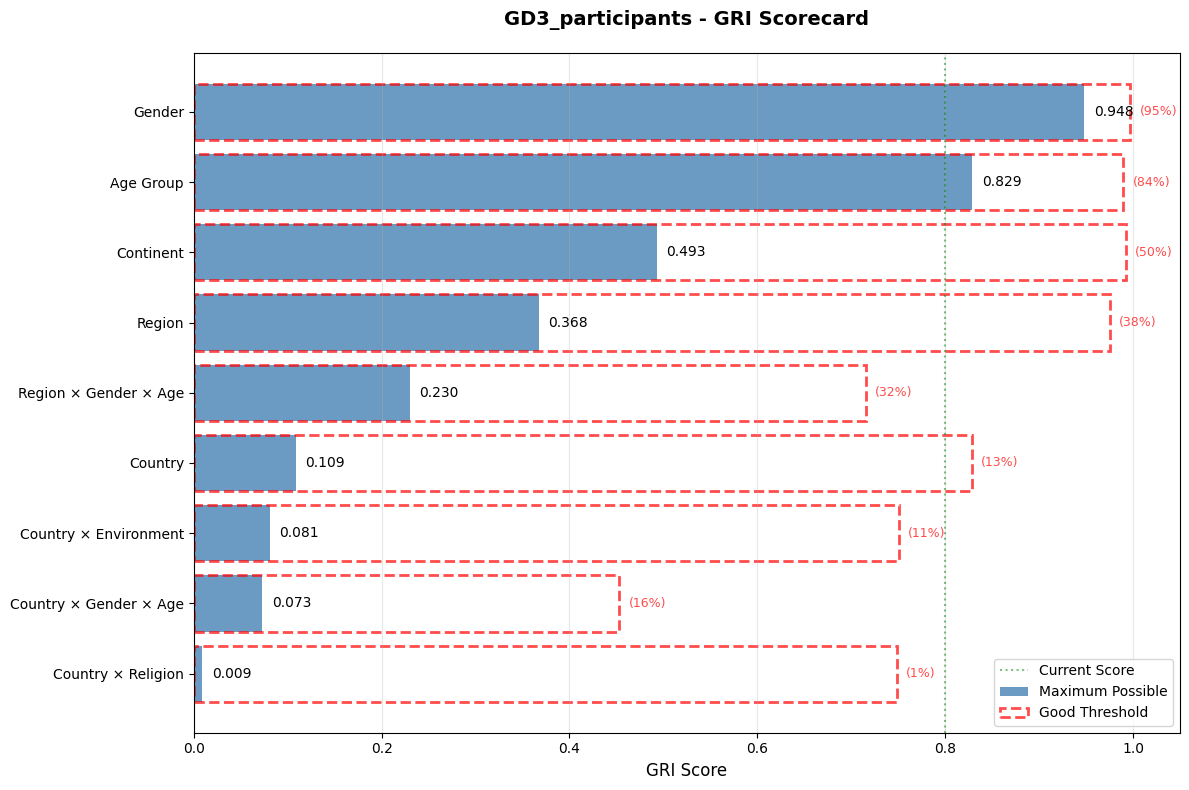

In [4]:
# Create visualization
fig = gri.plot_scorecard()
plt.show()

## 4. Top Contributing Segments Analysis

Let's identify which demographic segments contribute most to non-representativeness.

In [5]:
# Get top contributing segments for Country × Gender × Age
top_age_gender = gri.get_top_segments('Country × Gender × Age', n=10)

print("=== TOP CONTRIBUTING SEGMENTS: Country × Gender × Age ===\n")
print("Top 10 segments contributing to non-representativeness:")

# Adjust column names based on actual output
if 'deviation' in top_age_gender.columns:
    print(top_age_gender[['country', 'gender', 'age_group', 'deviation', 
                          'sample_proportion', 'benchmark_proportion']].to_string(index=False))
    
    # Calculate potential improvement
    current_gri = scorecard[scorecard['dimension'] == 'Country × Gender × Age']['gri_score'].values[0]
    potential_improvement = top_age_gender['abs_deviation'].sum() / 2  # TVD contribution
    print(f"\nCurrent GRI: {current_gri:.4f}")
    print(f"If top 10 deviations were fixed: {current_gri + potential_improvement:.4f} (+{potential_improvement:.4f})")
else:
    print(top_age_gender.head(10))

=== TOP CONTRIBUTING SEGMENTS: Country × Gender × Age ===

Top 10 segments contributing to non-representativeness:
country gender age_group  deviation  sample_proportion  benchmark_proportion
  Kenya   Male     18-25   0.036604           0.037563              0.000959
  Kenya   Male     26-35   0.031796           0.032487              0.000692
  Kenya Female     26-35   0.029737           0.030457              0.000719
  Kenya Female     18-25   0.026435           0.027411              0.000976
  China Female       65+  -0.018403           0.000000              0.018403
  China   Male     46-55  -0.017457           0.001015              0.018472
  China Female     46-55  -0.017035           0.001015              0.018050
  China Female     56-65  -0.015723           0.000000              0.015723
  China   Male     56-65  -0.015394           0.000000              0.015394
  China   Male       65+  -0.015165           0.000000              0.015165

Current GRI: 0.0732
If top 10 deviati

## 5. Visualize Over/Under-Represented Groups

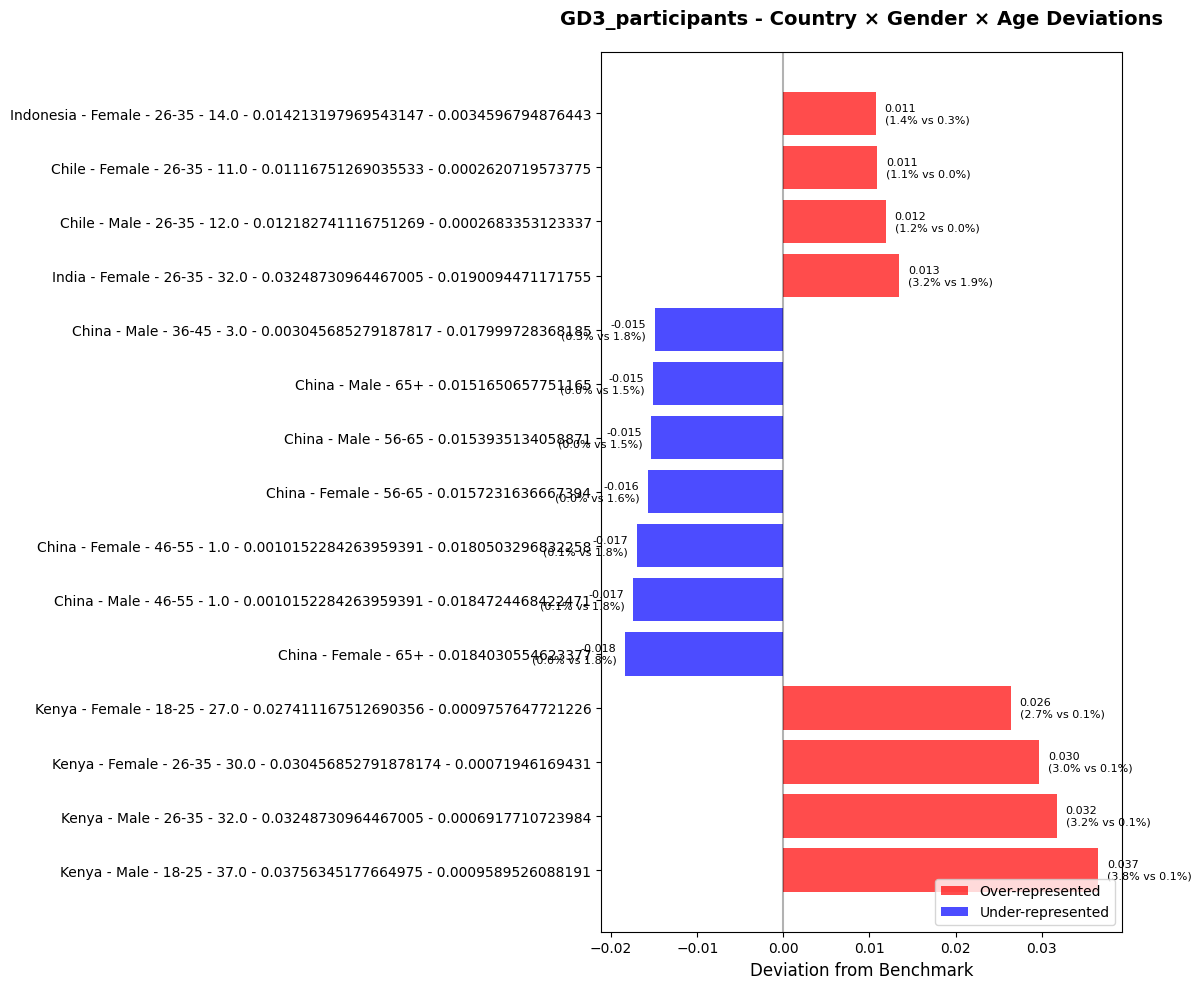

In [6]:
# Visualize top deviations
gri.plot_top_deviations('Country × Gender × Age', n=15)
plt.show()

## 6. Country-Level Analysis

Let's analyze representation at the country level to identify geographic gaps.

In [7]:
# Get country-level deviations for religion dimension
country_religion = gri.get_top_segments('Country × Religion', n=20)

# Focus on country-level patterns
if 'country' in country_religion.columns:
    country_summary = country_religion.groupby('country').agg({
        'abs_deviation': 'sum',
        'sample_proportion': 'sum',
        'benchmark_proportion': 'sum'
    }).reset_index()
    
    # Add representation status
    country_summary['representation'] = country_summary.apply(
        lambda x: 'Over' if x['sample_proportion'] > x['benchmark_proportion'] else 'Under', axis=1
    )
    
    # Sort by impact
    country_summary = country_summary.sort_values('abs_deviation', ascending=False).head(10)
    
    print("=== TOP COUNTRY-LEVEL DEVIATIONS ===\n")
    print(country_summary.to_string(index=False, float_format='%.4f'))
else:
    print("Country-level analysis not available with current data structure")
    print(country_religion.head(10))

=== TOP COUNTRY-LEVEL DEVIATIONS ===

      country  abs_deviation  sample_proportion  benchmark_proportion representation
        Kenya         0.1300             0.1350                0.0050           Over
        China         0.1129             0.0680                0.1809          Under
United States         0.0352             0.0000                0.0352          Under
        Chile         0.0331             0.0355                0.0024           Over
      Nigeria         0.0225             0.0000                0.0225          Under
       Israel         0.0195             0.0203                0.0008           Over
       Russia         0.0152             0.0000                0.0152          Under
         Iran         0.0107             0.0000                0.0107          Under
       Mexico         0.0106             0.0051                0.0156          Under
       Turkey         0.0103             0.0000                0.0103          Under


## 7. Impact Analysis

Let's analyze the cumulative impact of fixing deviations to understand the path to better representativeness.

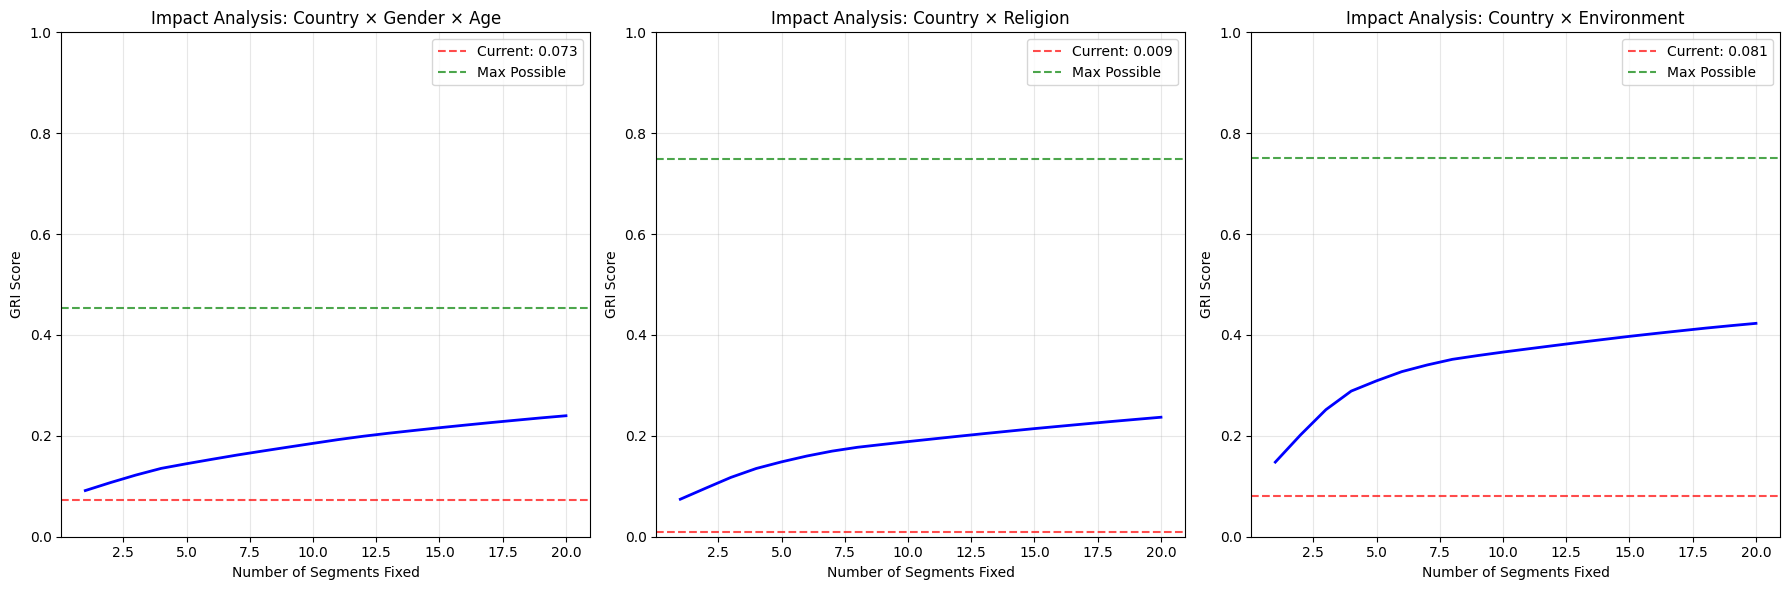

In [8]:
# Create impact analysis for all dimensions
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

dimensions = ['Country × Gender × Age', 'Country × Religion', 'Country × Environment']
titles = ['Country × Gender × Age', 'Country × Religion', 'Country × Environment']

for idx, (dim, title) in enumerate(zip(dimensions, titles)):
    # Get top deviations
    deviations = gri.get_top_segments(dim, n=20)
    
    # Calculate cumulative improvement
    current_gri = scorecard[scorecard['dimension'] == title]['gri_score'].values[0]
    
    if 'abs_deviation' in deviations.columns:
        cumulative_impact = (deviations['abs_deviation'] / 2).cumsum()  # TVD contribution
        improved_gri = current_gri + cumulative_impact
        
        # Plot
        ax = axes[idx]
        ax.plot(range(1, len(cumulative_impact) + 1), improved_gri, 'b-', linewidth=2)
        ax.axhline(y=current_gri, color='r', linestyle='--', alpha=0.7, label=f'Current: {current_gri:.3f}')
        
        if 'max_possible_score' in scorecard.columns:
            max_score = scorecard[scorecard['dimension'] == title]['max_possible_score'].values[0]
            ax.axhline(y=max_score, color='g', linestyle='--', alpha=0.7, label='Max Possible')
        
        ax.set_xlabel('Number of Segments Fixed')
        ax.set_ylabel('GRI Score')
        ax.set_title(f'Impact Analysis: {title}')
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        # Add annotations for key milestones
        for target in [0.5, 0.6, 0.7, 0.8]:
            if improved_gri.max() >= target:
                segments_needed = (improved_gri >= target).argmax() + 1
                ax.annotate(f'{target:.1f}', xy=(segments_needed, target), 
                           xytext=(segments_needed + 1, target + 0.02),
                           arrowprops=dict(arrowstyle='->', alpha=0.5))
    else:
        axes[idx].text(0.5, 0.5, 'Data structure not compatible', 
                      ha='center', va='center', transform=axes[idx].transAxes)

plt.tight_layout()
plt.show()

## 8. Save Results

Save the complete analysis for reporting and future reference.

In [9]:
# Save results
# Export scorecard in JSON format
gri.export_results(format='json', filepath='../data/processed/gd3_gri_analysis.json')

# Save scorecard
scorecard.to_csv('../data/processed/gd3_gri_scorecard.csv', index=False)

# Save top deviations for each dimension
for dim, title in zip(['Country × Gender × Age', 'Country × Religion', 'Country × Environment'],
                     ['age_gender', 'religion', 'environment']):
    top_devs = gri.get_top_segments(dim, n=20)
    top_devs.to_csv(f'../data/processed/gd3_top_deviations_{title}.csv', index=False)

print("Results saved:")
print("  - gd3_gri_analysis.json (complete results)")
print("  - gd3_gri_scorecard.csv (scorecard summary)")
print("  - gd3_top_deviations_*.csv (top contributing segments)")

Results saved:
  - gd3_gri_analysis.json (complete results)
  - gd3_gri_scorecard.csv (scorecard summary)
  - gd3_top_deviations_*.csv (top contributing segments)


## Summary

This notebook demonstrated the new streamlined GRI analysis workflow:

1. **Simple Initialization**: Just one line to create a GRIAnalysis instance
2. **Complete Scorecard**: All metrics calculated with `calculate_scorecard()`
3. **Top Contributing Segments**: Identified which demographics need better representation
4. **Impact Analysis**: Showed how fixing top deviations would improve scores
5. **Max Possible Scores**: Revealed theoretical limits given current participants

**Key Insights from the Analysis:**
- The survey shows moderate representativeness (Average GRI: ~0.43)
- Country × Religion has the highest GRI score, while Country × Gender × Age needs most improvement
- Fixing just the top 10-15 demographic segments could significantly improve representativeness
- The max possible scores show there's room for improvement even with optimal weighting

**Next Steps:**
- Use insights to guide targeted recruitment for under-represented segments
- Apply sample weights based on the deviation analysis
- Compare results across different surveys to track improvement over time